# Open Quantum Systems WS18-19

## Problem Sheet 12

The master equation approach in quantum physics: Numerical simulations of Lindblad equation

**[Iyán Méndez Veiga](mailto:iyan.mendez-veiga@uni-ulm.de)**

---

[**a)**](#a) $\Delta\Omega=0,\,J=0,\,\lambda_k=0$

[**b)**](#b) $\Delta\Omega=0,\,J=100,\,\lambda_k=10,\,\gamma_k=50,\,(k_BT/\hbar)=100$

[**c)**](#c) $\Delta\Omega=100,\,J=100,\,\lambda_k=10,\,\gamma_k=50,\,(k_BT/\hbar)=[100, 250, 400, 550]$

[**d)**](#d) $\Delta\Omega=100,\,J=100,\,\lambda_k=1000,\,\gamma_k=50,\,(k_BT/\hbar)=100$

[**e)**](#e) **Secular approximation** with same parameters from d)

[**f)**](#f) $\Delta\Omega=0,\,J=50,\,\lambda_k=50,\,\gamma_k=50,\,(k_BT/\hbar)=100$

## Exercise 26

In [2]:
from itertools import product
import numpy as np
from numpy.linalg import eig as diag
from numpy.linalg import inv
from scipy.constants import hbar
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
c = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b')
r2 = range(2)
save_plots = False

In [3]:
def save_fig(fig, name):
    fig.savefig('Figs/png/'+name+'.png', dpi=300)
    fig.savefig('Figs/eps/'+name+'.eps', dpi=300)
    fig.savefig('Figs/svg/'+name+'.svg', dpi=300)    

In [4]:
def RK4(f, y0, t0, tf, dt):
    # If dt is > 1 use as number of steps instead of difference in time between points
    if dt > 1:
        dt = (tf-t0)/dt
    tsol = np.arange(t0, tf+dt, dt)
    ysol = np.zeros((len(tsol), len(y0), len(y0)), dtype=np.complex)
    ysol[0] = y0.copy()

    for i in range(1, len(tsol)):
        F1 = dt * f(ysol[i-1], tsol[i-1])
        F2 = dt * f(ysol[i-1] + .5*F1, tsol[i-1] + .5*dt)
        F3 = dt * f(ysol[i-1] + .5*F2, tsol[i-1] + .5*dt)
        F4 = dt * f(ysol[i-1] + F3, tsol[i-1] + dt)
        ysol[i] = ysol[i-1] + 1/6 * (F1 + 2*F2 + 2*F3 + F4)
    
    return (tsol, ysol)

This functions permit to compute the population of the two sites, $P_1(t)$ and $P_2(t)$, and the inter-site coherence, $C_{21}(t)$. When transform flag is set to `True`, the input `rho` is assumed to be in the $H_s$ eigenbasis and the matrix is first converted to the site basis.

In [5]:
def P1(rho, transform=False):
    if transform:
        return np.real((eig_kets @ rho @ inv(eig_kets))[:,0,0])
    else:
        return np.real(rho[:,0,0])

def P2(rho, transform=False):
    if transform:
        return np.real((eig_kets @ rho @ inv(eig_kets))[:,1,1])
    else:
        return np.real(rho[:,1,1])

def C21(rho, transform=False):
    if transform:
        rho_t = eig_kets @ rho @ inv(eig_kets)
        real = np.real(rho_t[:,1,0])
        imag = np.imag(rho_t[:,1,0])
    else:
        real = np.real(rho[:,1,0])
        imag = np.imag(rho[:,1,0])
    c21 = (real,imag)    
    return c21

These are the functions $f(y,t)$ in the differential equation $dy(t)/dt=f(y,t)$ that I will use with Runge-Kutta in part different parts.

In [6]:
def transform_rho_a(rho_0, t=None):
    rho = rho_0.copy()
    rho[0,0] = 0
    rho[1,1] = 0
    rho[0,1] *= -1j * (eig_e[0] - eig_e[1])
    rho[1,0] *= -1j * (eig_e[1] - eig_e[0])
    return rho

In [7]:
def transform_rho_b(rho0, t=None):
    rho = rho0.copy()
    for k,l in product(r2, r2):
        rho[k,l] = -1j * (eig_e[k] - eig_e[l]) * rho0[k,l] + np.sum(R[k,l] * rho0)
    return rho

I define a function that I need to compute the dynamics of the reduced state when coupling to the thermal bath.

In [8]:
def Dn1(w, X, l, g):
    if abs(w) < 1e-10:
        return 2 * l / np.pi * X / g
    else:
        d = 2 * l / np.pi * w * g / (w**2 + g**2)
        n = 1 / (np.exp(w/X) - 1)
        return d * (n + 1)

I also define the Redfield tensor

In [9]:
def redfield_tensor(X, Lambda, Gamma):
    G = np.zeros((2,2,2,2), dtype=np.complex)
    R = np.zeros((2,2,2,2), dtype=np.complex)
    s = (np.array([1,0]).reshape(2,1), np.array([0,1]).reshape(2,1))
    ev = (eig_kets[:,0].reshape(2,1), eig_kets[:,1].reshape(2,1))

    for k,l,k_,l_,m in product(r2,r2,r2,r2,r2):
        prod = ev[k].conj().T @ s[m] * s[m].conj().T @ ev[l] * ev[k_].conj().T @ s[m] * s[m].conj().T @ ev[l_]
        G[k,l,k_,l_] += prod * np.pi * Dn1(eig_e[l_] - eig_e[k_], X, Lambda, Gamma)
    
    for k,l,k_,l_ in product(r2,r2,r2,r2):
        R[k,l,k_,l_] += G[l_,l,k,k_] + np.conj(G[k_,k,l,l_])
        if l == l_:
            for m in r2:
                R[k,l,k_,l_] -= G[k,m,m,k_]
        if k == k_:
            for m in r2:
                R[k,l,k_,l_] -= np.conj(G[l,m,m,l_])
    return R

I define the negativity of the reduced system state $\hat{\rho}_s(t)$ as the sum of its negative eigenvalues. This function is used in parts **d)** and **e)**.

In [10]:
def negativity(rho):
    l = rho.shape[0]
    neg = np.zeros(l)
    rho_eig,_ = diag(rho)
    rho_eig = np.real(rho_eig)
    for i,r in enumerate(rho_eig):
        neg[i] = np.sum(r[r < 0])
    return neg

In [11]:
def negativity_alt(rho):
    rho_eig,_ = diag(rho)
    rho_eig = np.real(rho_eig)
    return np.min(rho_eig[:,], axis=1)

A function to apply the secular approximation to a given Redfield tensor.

In [12]:
def secular_approximation(R):
    R_secular = R.copy()
    for k,l,k_,l_ in product(r2, r2, r2, r2):
        condition = abs((eig_e[k] - eig_e[l]) - (eig_e[k_] - eig_e[l_]))
        if condition > 1e-16:
            R_secular[k,l,k_,l_] = 0
    return R_secular

---

<div id='a' />

### a) $\Delta\Omega=0,\,J=0,\,\lambda_k=0$

In [13]:
t_start = 0
t_end = 1
d_omega = 0
Omega_2 = 1
Omega_1 = Omega_2 + d_omega
J = 100
rho_0 = np.array([[1,0],[0,0]], dtype=np.complex)
print(rho_0)

[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


Hamiltonian of the system $\hat{H}_s$, and its eigenvalues and eigenkets.

In [14]:
H_s = np.array(
    [[Omega_1, J],
     [J, Omega_2]])
H_s

array([[  1, 100],
       [100,   1]])

In [15]:
eig_e, eig_kets = diag(H_s)
print(eig_e)
print(eig_kets)
rho_0_eig = inv(eig_kets) @ rho_0 @ eig_kets

[101. -99.]
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


In [16]:
t_sol_a, rho_sol_a = RK4(transform_rho_a, rho_0_eig, t_start, t_end, 10000)

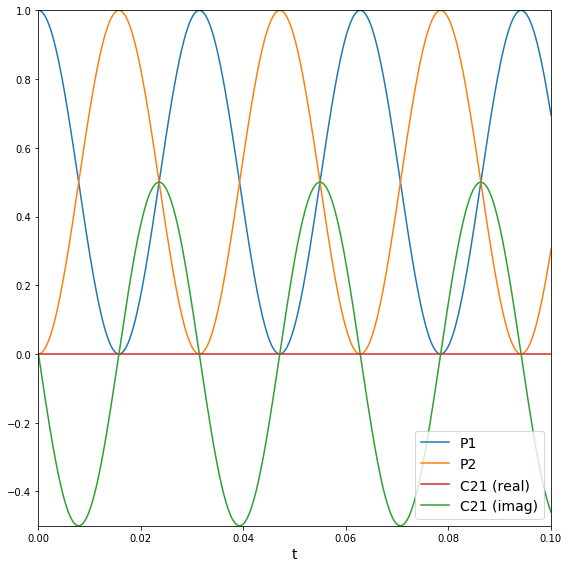

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(t_sol_a, P1(rho_sol_a, True), '-', color=c[0], label='P1')
ax.plot(t_sol_a, P2(rho_sol_a, True), '-', color=c[1], label='P2')
ax.plot(t_sol_a, C21(rho_sol_a, True)[0], '-', color=c[3], label='C21 (real)')
ax.plot(t_sol_a, C21(rho_sol_a, True)[1], '-', color=c[2], label='C21 (imag)')
ax.set_xbound(0,.1)
ax.set_ybound(-.5,1)
ax.set_xlabel('t', fontsize=14)
ax.legend(loc=4, fontsize=14)
plt.tight_layout();
if save_plots:
    save_fig(fig, 'PS12_26a_populations')

<div id='b' />

### b) $\Delta\Omega=0,\,J=100,\,\lambda_k=10,\,\gamma_k=50,\,(k_BT/\hbar)=100$

In [18]:
t_start = 0
t_end = 2.5
d_omega = 0
Omega_2 = 1
Omega_1 = Omega_2 + d_omega
J = 100
lambda_k = 10
gamma_k = 50
X = 100
rho_0 = np.array([[1,0],[0,0]], dtype=np.complex)

In [19]:
H_s = np.array(
    [[Omega_1, J],
     [J, Omega_2]])

In [20]:
eig_e, eig_kets = diag(H_s)
print(eig_e)
print(eig_kets)
rho_0_eig = inv(eig_kets) @ rho_0 @ eig_kets

[101. -99.]
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


In [21]:
R = redfield_tensor(X, lambda_k, gamma_k)

In [22]:
t_sol_b, rho_sol_b = RK4(transform_rho_b, rho_0_eig, t_start, t_end, 0.001)

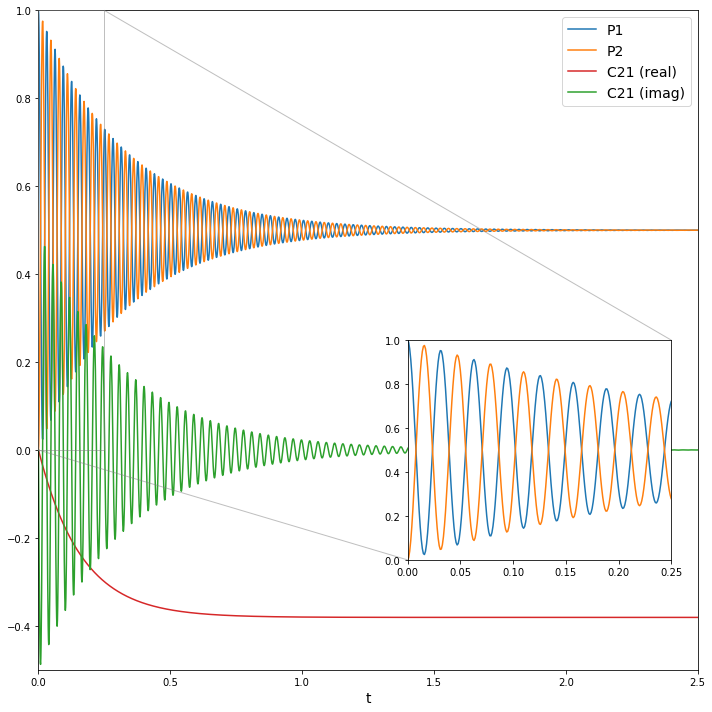

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(t_sol_b, P1(rho_sol_b, True), '-', color=c[0], label='P1')
ax.plot(t_sol_b, P2(rho_sol_b, True), '-', color=c[1], label='P2')
ax.plot(t_sol_b, C21(rho_sol_b, True)[0], '-', color=c[3], label='C21 (real)')
ax.plot(t_sol_b, C21(rho_sol_b, True)[1], '-', color=c[2], label='C21 (imag)')
ax.set_xbound(0,2.5)
ax.set_ybound(-.5,1)
ax.legend(loc=0, fontsize=14)

# Zoom area
axins = ax.inset_axes([1.4, -0.25, 1, 0.5], transform=ax.transData)
axins.plot(t_sol_b, P1(rho_sol_b, True), '-', color=c[0])
axins.plot(t_sol_b, P2(rho_sol_b, True), '-', color=c[1])
axins.set_xlim(0, .25)
axins.set_ylim(0, 1)
ax.indicate_inset_zoom(axins)

ax.set_xlabel('t', fontsize=14)
plt.tight_layout();

if save_plots:
    save_fig(fig, 'PS12_26b_populations')

<div id='c' />

### c) $\Delta\Omega=100,\,J=100,\,\lambda_k=10,\,\gamma_k=50,\,(k_BT/\hbar)=[100, 250, 400, 550]$

In [24]:
t_start = 0
t_end = 1
d_omega = 100
Omega_2 = 1
Omega_1 = Omega_2 + d_omega
J = 100
lambda_k = 10
gamma_k = 50
X = 100
rho_0 = np.array([[1,0],[0,0]], dtype=np.complex)

In [25]:
H_s = np.array(
    [[Omega_1, J],
     [J, Omega_2]])

In [26]:
eig_e, eig_kets = diag(H_s)
print(eig_e)
print(eig_kets)
rho_0_eig = inv(eig_kets) @ rho_0 @ eig_kets

[162.80339887 -60.80339887]
[[ 0.85065081 -0.52573111]
 [ 0.52573111  0.85065081]]


In [27]:
X = 100
print(X, lambda_k, gamma_k)
R = redfield_tensor(X, lambda_k, gamma_k)
t_sol_c1, rho_sol_c1 = RK4(transform_rho_b, rho_0_eig, t_start, t_end, 100000)

X = 250
print(X, lambda_k, gamma_k)
R = redfield_tensor(X, lambda_k, gamma_k)
t_sol_c2, rho_sol_c2 = RK4(transform_rho_b, rho_0_eig, t_start, t_end, 100000)

X = 400
print(X, lambda_k, gamma_k)
R = redfield_tensor(X, lambda_k, gamma_k)
t_sol_c3, rho_sol_c3 = RK4(transform_rho_b, rho_0_eig, t_start, t_end, 100000)

X = 550
print(X, lambda_k, gamma_k)
R = redfield_tensor(X, lambda_k, gamma_k)
t_sol_c4, rho_sol_c4 = RK4(transform_rho_b, rho_0_eig, t_start, t_end, 100000)

100 10 50
250 10 50
400 10 50
550 10 50


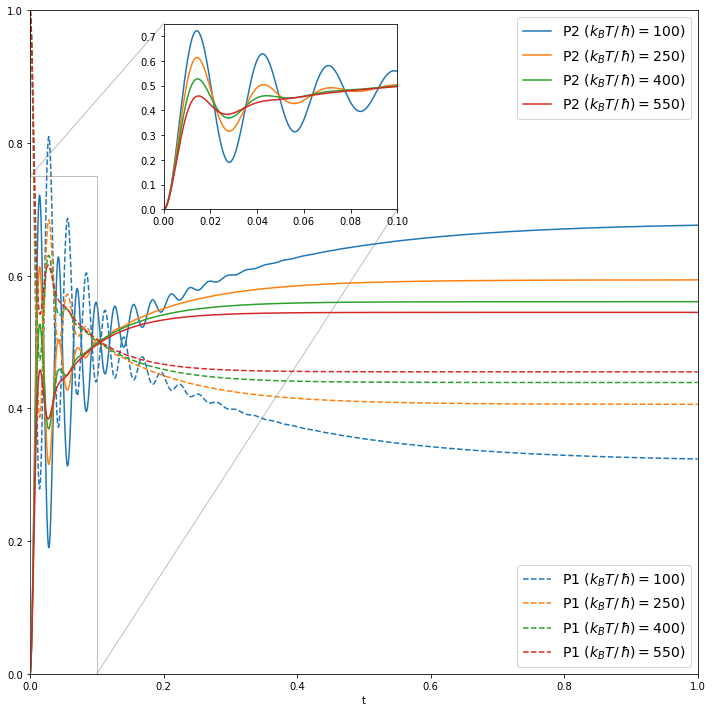

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
p11, = ax.plot(t_sol_c1, P1(rho_sol_c1, True), '--', color=c[0])
p12, = ax.plot(t_sol_c1, P2(rho_sol_c1, True), '-', color=c[0])
p21, = ax.plot(t_sol_c2, P1(rho_sol_c2, True), '--', color=c[1])
p22, = ax.plot(t_sol_c2, P2(rho_sol_c2, True), '-', color=c[1])
p31, = ax.plot(t_sol_c3, P1(rho_sol_c3, True), '--', color=c[2])
p32, = ax.plot(t_sol_c3, P2(rho_sol_c3, True), '-', color=c[2])
p41, = ax.plot(t_sol_c4, P1(rho_sol_c4, True), '--', color=c[3])
p42, = ax.plot(t_sol_c4, P2(rho_sol_c4, True), '-', color=c[3])

l1 = ax.legend([p11, p21, p31, p41],
               [r'P1 $(k_BT/\,\hbar)=100$)',
                r'P1 $(k_BT/\,\hbar)=250$)',
                r'P1 $(k_BT/\,\hbar)=400$)',
                r'P1 $(k_BT/\,\hbar)=550$)'], loc=4, fontsize=14);

l2 = ax.legend([p12, p22, p32, p42],
               [r'P2 $(k_BT/\,\hbar)=100$)',
                r'P2 $(k_BT/\,\hbar)=250$)',
                r'P2 $(k_BT/\,\hbar)=400$)',
                r'P2 $(k_BT/\,\hbar)=550$)'], loc=1, fontsize=14);
gca().add_artist(l1)

axins = ax.inset_axes([.2, .7, .35, .28], transform=ax.transData)
#axins.plot(t_sol_c1, P1(rho_sol_c1, True), '--', color=c[0])
axins.plot(t_sol_c1, P2(rho_sol_c1, True), '-', color=c[0])
#axins.plot(t_sol_c2, P1(rho_sol_c2, True), '--', color=c[1])
axins.plot(t_sol_c2, P2(rho_sol_c2, True), '-', color=c[1])
#axins.plot(t_sol_c3, P1(rho_sol_c3, True), '--', color=c[2])
axins.plot(t_sol_c3, P2(rho_sol_c3, True), '-', color=c[2])
#axins.plot(t_sol_c4, P1(rho_sol_c4, True), '--', color=c[3])
axins.plot(t_sol_c4, P2(rho_sol_c4, True), '-', color=c[3])
axins.set_xlim(0, .1)
axins.set_ylim(0, .75)
ax.indicate_inset_zoom(axins)

ax.set_xbound(0,1)
ax.set_ybound(0,1)
ax.set_xlabel('t', fontsize=10)
plt.tight_layout();

if save_plots:
    save_fig(fig, 'PS12_26c_populations')

<div id='d' />

### d) $\Delta\Omega=100,\,J=100,\,\lambda_k=1000,\,\gamma_k=50,\,(k_BT/\hbar)=100$

In [29]:
t_start = 0
t_end = 1
d_omega = 100
Omega_2 = 1
Omega_1 = Omega_2 + d_omega
J = 100
lambda_k = 1000
gamma_k = 50
X = 100
rho_0 = np.array([[1,0],[0,0]], dtype=np.complex)

In [30]:
H_s = np.array(
    [[Omega_1, J],
     [J, Omega_2]])

In [31]:
eig_e, eig_kets = diag(H_s)
print(eig_e)
print(eig_kets)
rho_0_eig = inv(eig_kets) @ rho_0 @ eig_kets

[162.80339887 -60.80339887]
[[ 0.85065081 -0.52573111]
 [ 0.52573111  0.85065081]]


In [32]:
print(X, lambda_k, gamma_k)
R = redfield_tensor(X, lambda_k, gamma_k)

100 1000 50


In [33]:
t_sol_d, rho_sol_d = RK4(transform_rho_b, rho_0_eig, t_start, t_end, 100000)

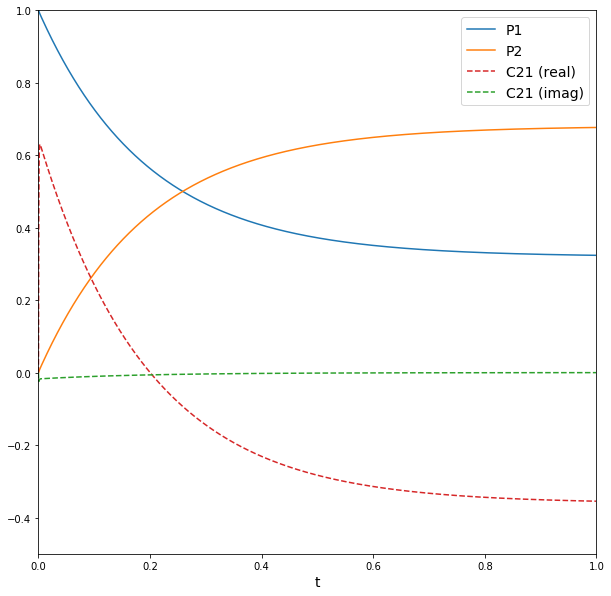

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(t_sol_d, P1(rho_sol_d, True), '-', color=c[0], label='P1')
ax.plot(t_sol_d, P2(rho_sol_d, True), '-', color=c[1], label='P2')
ax.plot(t_sol_d, C21(rho_sol_d, True)[0], '--', color=c[3], label='C21 (real)')
ax.plot(t_sol_d, C21(rho_sol_d, True)[1], '--', color=c[2], label='C21 (imag)')
ax.set_xbound(0,1)
ax.set_ybound(-.5,1)
ax.set_xlabel('t', fontsize=14)
ax.legend(loc=0, fontsize=14);

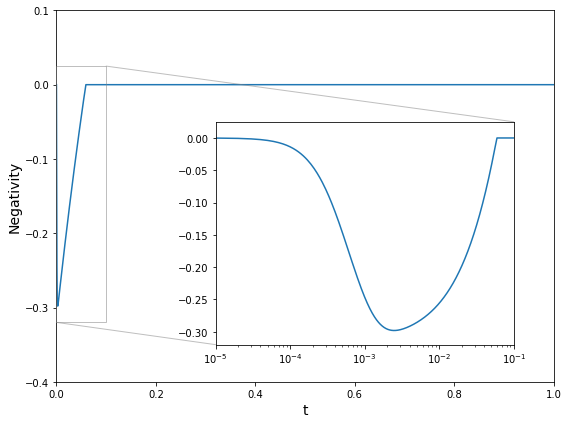

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(t_sol_d, negativity(rho_sol_d), '-', color=c[0])
ax.set_xbound(0,1)
ax.set_ybound(-.4,.1)
ax.set_xlabel('t', fontsize=14);
ax.set_ylabel('Negativity', fontsize=14);

axins = ax.inset_axes([.32, -.35, .6, .3], transform=ax.transData)
axins.semilogx(t_sol_d, negativity(rho_sol_d), '-', color=c[0])
axins.set_xlim(0.00001, .1)
axins.set_ylim(-.32, .025)
ax.indicate_inset_zoom(axins)

plt.tight_layout();

if save_plots:
    save_fig(fig, 'PS12_26d_negativity')

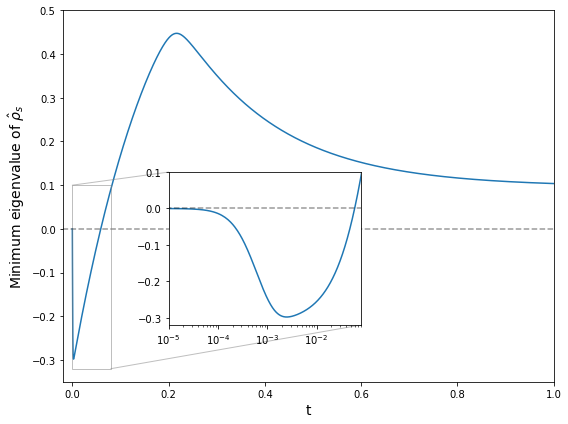

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(t_sol_d, negativity_alt(rho_sol_d), '-', color=c[0])
ax.plot([-1,2], [0,0], 'k--', alpha=0.4)
ax.set_xbound(-0.02,1)
ax.set_ybound(-.35,.5)
ax.set_xlabel('t', fontsize=14);
ax.set_ylabel(r'Minimum eigenvalue of $\hat{\rho}_s$', fontsize=14);

axins = ax.inset_axes([.2, -.22, .4, .35], transform=ax.transData)
axins.semilogx(t_sol_d, negativity_alt(rho_sol_d), '-', color=c[0])
axins.plot([-1,2], [0,0], 'k--', alpha=0.4)
axins.set_xlim(0.00001, .08)
axins.set_ylim(-.32, .1)
ax.indicate_inset_zoom(axins)

plt.tight_layout();

if save_plots:
    save_fig(fig, 'PS12_26d_negativity_alt')

<div id='e' />

### e) Secular approximation

In [37]:
t_start = 0
t_end = 1
d_omega = 100
Omega_2 = 1
Omega_1 = Omega_2 + d_omega
J = 100
lambda_k = 1000
gamma_k = 50
X = 100
rho_0 = np.array([[1,0],[0,0]], dtype=np.complex)

In [38]:
H_s = np.array(
    [[Omega_1, J],
     [J, Omega_2]])

In [39]:
eig_e, eig_kets = diag(H_s)
print(eig_e)
print(eig_kets)
rho_0_eig = inv(eig_kets) @ rho_0 @ eig_kets

[162.80339887 -60.80339887]
[[ 0.85065081 -0.52573111]
 [ 0.52573111  0.85065081]]


In [40]:
R = redfield_tensor(X, lambda_k, gamma_k)

In [41]:
t_sol_e, rho_sol_e = RK4(transform_rho_b, rho_0_eig, t_start, t_end, 100000)

In [42]:
R = secular_approximation(R)

In [43]:
t_sol_e2, rho_sol_e2 = RK4(transform_rho_b, rho_0_eig, t_start, t_end, 100000)

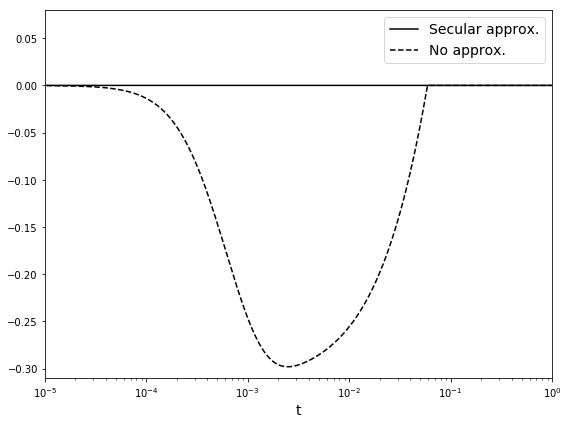

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.semilogx(t_sol_e2, negativity(rho_sol_e2), 'k-', label='Secular approx.')
ax.semilogx(t_sol_e, negativity(rho_sol_e), 'k--', label='No approx.')
ax.set_xbound(0.00001,1)
ax.set_ybound(-.31,.08)
ax.set_xlabel('t', fontsize=14)
ax.legend(loc=0, fontsize=14);

plt.tight_layout();

if save_plots:
    save_fig(fig, 'PS12_26e_negativity')

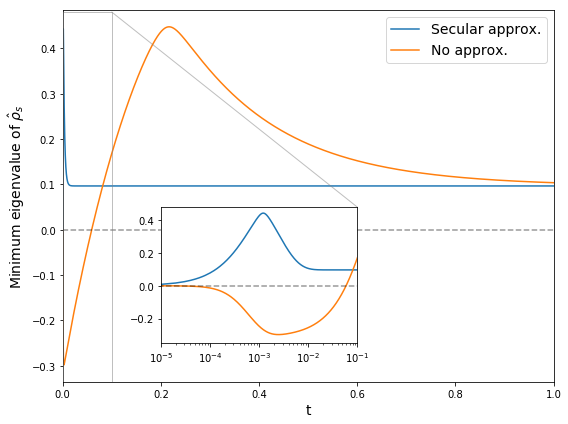

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(t_sol_e2, negativity_alt(rho_sol_e2), '-', color=c[0], label='Secular approx.')
ax.plot(t_sol_e, negativity_alt(rho_sol_e), '-', color=c[1], label='No approx.')
ax.plot([-1,2], [0,0], 'k--', alpha=0.4)
ax.set_xbound(0.00001,1)
#ax.set_ybound(-.31,.08)
ax.set_xlabel('t', fontsize=14)
ax.set_ylabel(r'Minimum eigenvalue of $\hat{\rho}_s$', fontsize=14);
ax.legend(loc=0, fontsize=14);

axins = ax.inset_axes([.2, -.25, .4, .3], transform=ax.transData)
axins.semilogx(t_sol_e2, negativity_alt(rho_sol_e2), '-', color=c[0])
axins.semilogx(t_sol_e, negativity_alt(rho_sol_e), '-', color=c[1])
axins.plot([-1,2], [0,0], 'k--', alpha=0.4)
axins.set_xlim(0.00001, .1)
axins.set_ylim(-.35, .48)
ax.indicate_inset_zoom(axins)

plt.tight_layout();

if save_plots:
    save_fig(fig, 'PS12_26e_negativity_alt')

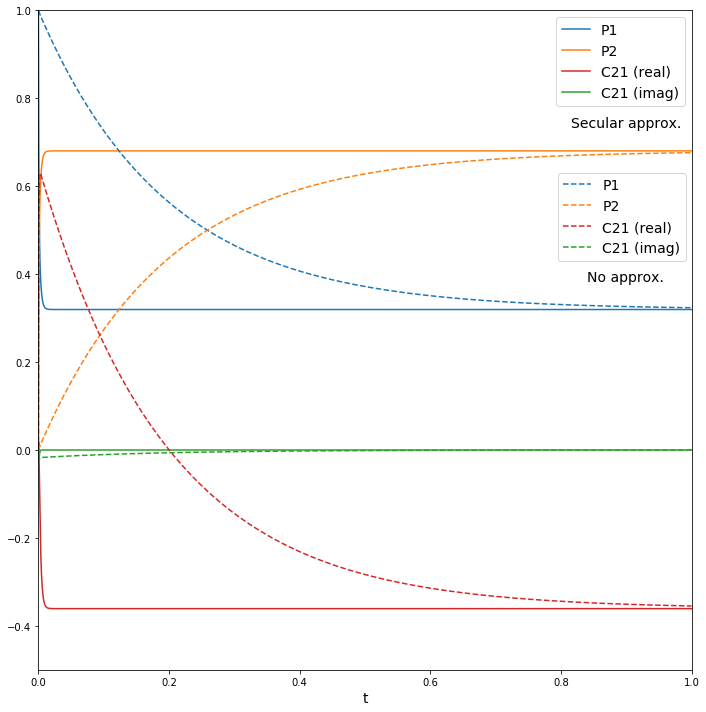

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
p1a, = ax.plot(t_sol_e2, P1(rho_sol_e2, True), '-', color=c[0])
p2a, = ax.plot(t_sol_e2, P2(rho_sol_e2, True), '-', color=c[1])
c21ra, = ax.plot(t_sol_e2, C21(rho_sol_e2, True)[0], '-', color=c[3])
c21ia, = ax.plot(t_sol_e2, C21(rho_sol_e2, True)[1], '-', color=c[2])

p1, = ax.plot(t_sol_e, P1(rho_sol_e, True), '--', color=c[0])
p2, = ax.plot(t_sol_e, P2(rho_sol_e, True), '--', color=c[1])
c21r, = ax.plot(t_sol_e, C21(rho_sol_e, True)[0], '--', color=c[3])
c21i, = ax.plot(t_sol_e, C21(rho_sol_e, True)[1], '--', color=c[2])

l1 = ax.legend([p1a, p2a, c21ra, c21ia],
               ['P1', 'P2', 'C21 (real)', 'C21 (imag)'], loc=1, fontsize=14);

l2 = ax.legend([p1, p2, c21r, c21i],
               ['P1', 'P2', 'C21 (real)', 'C21 (imag)'], loc=(.795,.62), fontsize=14);
gca().add_artist(l1)

ax.text(.815, .735, "Secular approx.", fontsize=14)
ax.text(.84, .385, "No approx.", fontsize=14)

ax.set_xbound(0,1)
ax.set_ybound(-.5,1)
ax.set_xlabel('t', fontsize=14)

plt.tight_layout();

if save_plots:
    save_fig(fig, 'PS12_26e_populations')

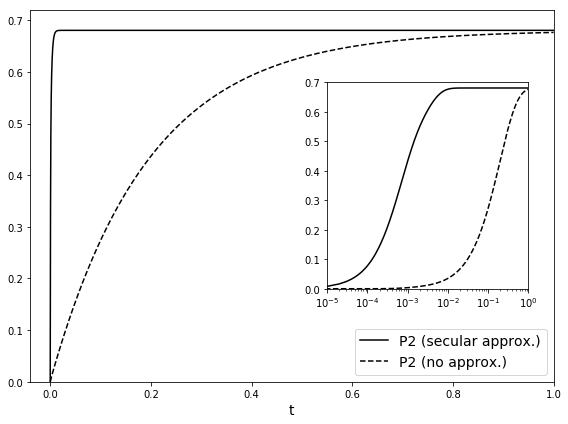

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(t_sol_e2, P2(rho_sol_e2, True), 'k-', label='P2 (secular approx.)')
ax.plot(t_sol_e, P2(rho_sol_e, True), 'k--', label='P2 (no approx.)')
ax.set_xbound(-.04, 1)
ax.set_ybound(0,0.72)
ax.set_xlabel('t', fontsize=14)
ax.legend(loc=0, fontsize=14)

axins = ax.inset_axes([.55, .18, .4, .4], transform=ax.transData)
axins.semilogx(t_sol_e, P2(rho_sol_e, True), 'k--')
axins.semilogx(t_sol_e2, P2(rho_sol_e2, True), 'k-')
axins.set_xlim(0.00001, 1)
axins.set_ylim(0, .7)
#ax.indicate_inset_zoom(axins)

plt.tight_layout();

if save_plots:
    save_fig(fig, 'PS12_26e_comparison')

<div id='f' />

### f) $\Delta\Omega=0,\,J=50,\,\lambda_k=50,\,\gamma_k=50,\,(k_BT/\hbar)=100$

In [48]:
t_start = 0
t_end = 1
d_omega = 0
Omega_2 = 1
Omega_1 = Omega_2 + d_omega
J = 50
lambda_k = 50
gamma_k = 50
X = 100

In [49]:
H_s = np.array(
    [[Omega_1, J],
     [J, Omega_2]])

In [50]:
eig_e, eig_kets = diag(H_s)
print(eig_e)
print(eig_kets)
rho_0_eig = inv(eig_kets) @ rho_0 @ eig_kets

[ 51. -49.]
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


In [51]:
R = redfield_tensor(X, lambda_k, gamma_k)

In [52]:
t_sol_f1, rho_sol_f1 = RK4(transform_rho_b, rho_0_eig, t_start, t_end, 10000)

In [53]:
R = secular_approximation(R)

In [54]:
t_sol_f2, rho_sol_f2 = RK4(transform_rho_b, rho_0_eig, t_start, t_end, 10000)

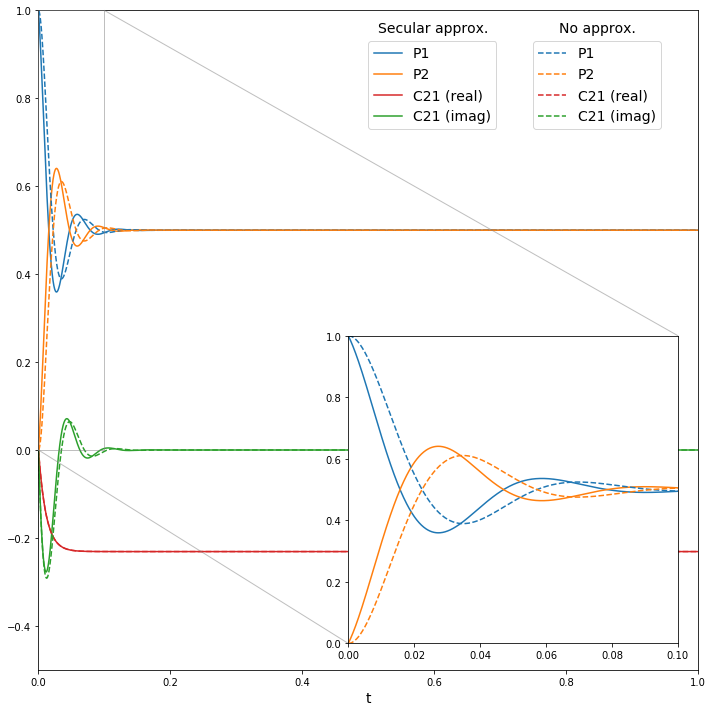

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
p1a, = ax.plot(t_sol_f2, P1(rho_sol_f2, True), '-', color=c[0])
p2a, = ax.plot(t_sol_f2, P2(rho_sol_f2, True), '-', color=c[1])
c21ra, = ax.plot(t_sol_f2, C21(rho_sol_f2, True)[0], '-', color=c[3])
c21ia, = ax.plot(t_sol_f2, C21(rho_sol_f2, True)[1], '-', color=c[2])

p1, = ax.plot(t_sol_f1, P1(rho_sol_f1, True), '--', color=c[0])
p2, = ax.plot(t_sol_f1, P2(rho_sol_f1, True), '--', color=c[1])
c21r, = ax.plot(t_sol_f1, C21(rho_sol_f1, True)[0], '--', color=c[3])
c21i, = ax.plot(t_sol_f1, C21(rho_sol_f1, True)[1], '--', color=c[2])

l1 = ax.legend([p1a, p2a, c21ra, c21ia],
               ['P1', 'P2', 'C21 (real)', 'C21 (imag)'], loc=(.5,.82), fontsize=14);

l2 = ax.legend([p1, p2, c21r, c21i],
               ['P1', 'P2', 'C21 (real)', 'C21 (imag)'], loc=(.75,.82), fontsize=14);
gca().add_artist(l1)

ax.text(.515, .95, "Secular approx.", fontsize=14)
ax.text(.79, .95, "No approx.", fontsize=14)

ax.set_xbound(0,1)
ax.set_ybound(-.5,1)
ax.set_xlabel('t', fontsize=14)

axins = ax.inset_axes([.47, -.44, .5, .7], transform=ax.transData)
axins.plot(t_sol_f2, P1(rho_sol_f2, True), '-', color=c[0])
axins.plot(t_sol_f2, P2(rho_sol_f2, True), '-', color=c[1])
axins.plot(t_sol_f2, P1(rho_sol_f1, True), '--', color=c[0])
axins.plot(t_sol_f1, P2(rho_sol_f1, True), '--', color=c[1])
axins.set_xlim(0, .1)
axins.set_ylim(0, 1)
ax.indicate_inset_zoom(axins)

plt.tight_layout();

if save_plots:
    save_fig(fig, 'PS12_26f_populations')